# Import Library

In [1]:
import numpy as np
import math
import natsort
import cv2
import os
import matplotlib.pyplot as plt
from google.colab import drive
from glob import glob

from PIL import Image
from skimage.io import imread

import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loder

In [3]:
def sortlist(filelist):
    filelist = natsort.natsorted(filelist)
    return filelist

In [4]:
dir_path = '/content/drive/MyDrive/Cloud_data/cloud_train'
# input_images = glob(os.path.join(dir_path, "patch_img", "*png"))
# input_images = sortlist(input_images)

In [5]:
class CloudGenerator(Sequence):
    def __init__(self,
                 dir_path,
                 batch_size = 1,
                 img_size = (1000,1000,3),
                 output_size = (1000,1000),
                 is_train = True):
        
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.output_size = output_size
        self.is_train = is_train

        self.data = self.load_dataset()
    
    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path,"patch_img","*png"))
        label_images = glob(os.path.join(self.dir_path,"patch_label","*png"))
        input_images = sortlist(input_images)
        label_images = sortlist(label_images)
        input_images = input_images[:25*27] # 27번째 사진이 5000이 안되서 임의적으로 
        label_images = label_images[:25*27] # 26번째 사진까지만 학습해봄
        
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        train_percent = int(len(data) * 0.8)

        if self.is_train:
            return data[:train_percent]
        return data[train_percent:]

    def __getitem__(self, index):
        batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size]) #1000,1000
            
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data

            _input = cv2.imread(input_img_path)
            _output = cv2.imread(output_path,0) # 1000,1000

            _output = (_output==50).astype(np.uint8)*1
            inputs[i] = _input/255
            outputs[i] = _output
            
            return inputs, outputs

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [6]:
train_generator = CloudGenerator(
    dir_path,
    is_train=True
)

test_generator = CloudGenerator(
    dir_path,
    is_train=False
)

# Build U-net Model

In [8]:
def build_unet_model(input_shape=(1000, 1000, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    # #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 3, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [9]:
unet_model = build_unet_model()
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 1000,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1000, 1000,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1000, 1000,   36928       ['conv2d[0][0]']                 
                                64)                                                           

In [11]:
unet_model_path = '/content/drive/MyDrive/Cloud_data/cloud_model/seg_unet_model.h5'

unet_model = build_unet_model()
unet_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
unet_model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=10,
 )

unet_model.save(unet_model_path)  #학습한 모델을 저장해 주세요.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/10
540/540 [==============================] - 613s 1s/step - loss: 0.2667 - val_loss: 0.1755
Epoch 2/10
540/540 [==============================] - 254s 471ms/step - loss: 0.1652 - val_loss: 0.1713
Epoch 3/10
540/540 [==============================] - 254s 470ms/step - loss: 0.1578 - val_loss: 0.1591
Epoch 4/10
540/540 [==============================] - 254s 470ms/step - loss: 0.1548 - val_loss: 0.1709
Epoch 5/10
540/540 [==============================] - 254s 470ms/step - loss: 0.1433 - val_loss: 0.1614
Epoch 6/10
540/540 [==============================] - 254s 470ms/step - loss: 0.1390 - val_loss: 0.1959
Epoch 7/10
540/540 [==============================] - 254s 470ms/step - loss: 0.1323 - val_loss: 0.1426
Epoch 8/10
540/540 [==============================] - 254s 470ms/step - loss: 0.1276 - val_loss: 0.2017
Epoch 9/10
540/540 [==============================] - 254s 470ms/step - loss: 0.1199 - val_loss: 0.1332
Epoch 10/10
540/540 [==============================] - 253s 469ms/s

# Load U-netModel

In [12]:
Unet_model = tf.keras.models.load_model(unet_model_path)

In [66]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    print(union)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [73]:
def get_output(model, image_path, output_path, label_path):
    origin_img = cv2.imread(image_path)
    output = model(np.expand_dims(origin_img/255, axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
   
    if label_path:   
        label_img = cv2.imread(label_path,0)
        target = (label_img == 50).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [75]:
 #dir_path = '/content/drive/MyDrive/Cloud_data/cloud_train'

i = 1
j = 1
output, prediction, target = get_output(
     Unet_model, 
     image_path = dir_path + f'/patch_img/img{i}_{j}.png',
     output_path = dir_path + f'/output_test/img{i}_{j}.png',
     label_path = dir_path + f'/patch_label/img{i}_{j}.png'
 )

# calculate_iou_score(target, prediction)

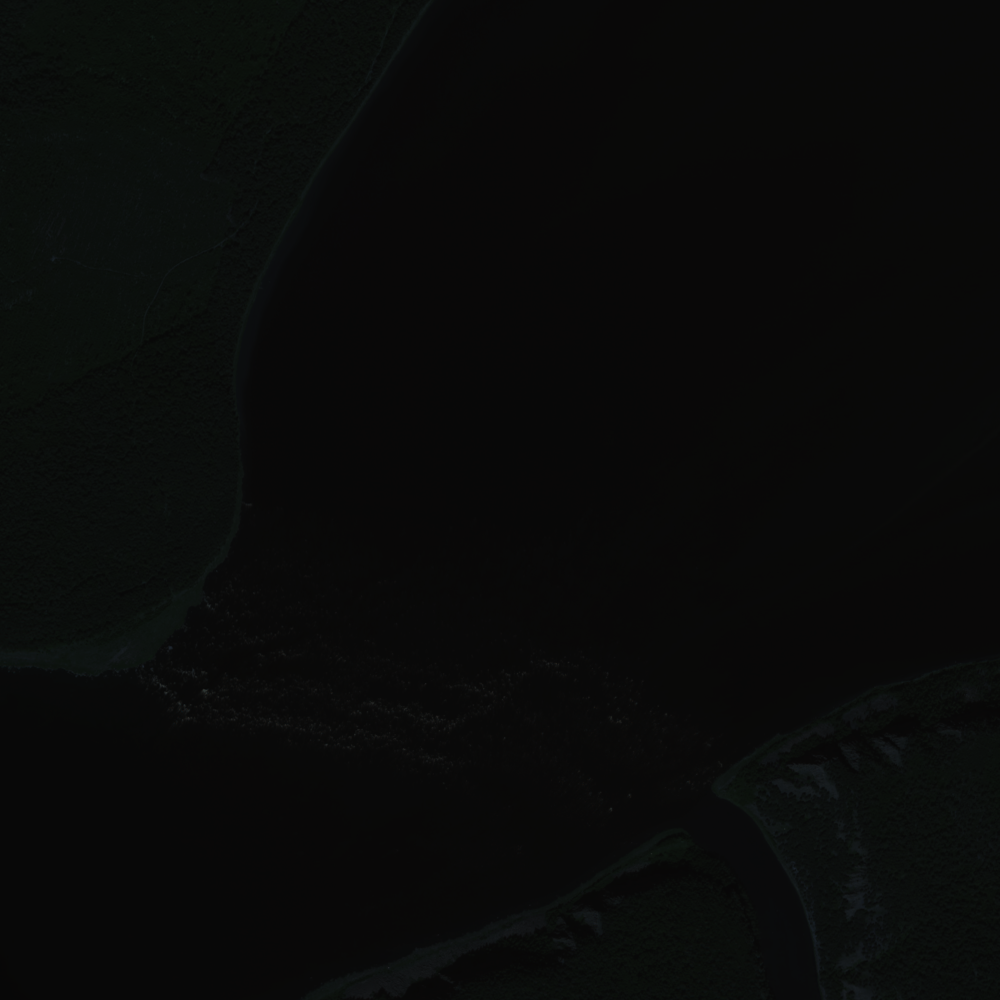

In [83]:
output